Oli Kosiacki's Machine Learning Analysis

In [2]:
%pip install pandas scikit-learn matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [67]:
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Oli\AppData\Local\Temp\ipykernel_26548\3972011310.py:2: DtypeWarning: Columns (7,12,13,14,21,22,32,33,44) have mixed types. Specify dtype option on import or set low_memory=False.
  plane_data = pd.read_csv('data/Merged10yrdata.csv')



Classification Report (2022–2023 known reports):
              precision    recall  f1-score   support

       1-120       0.28      0.10      0.14       959
     121-240       0.24      0.70      0.36       717
     241-360       0.17      0.07      0.10       261
     361-480       0.09      0.02      0.03       214
     481-600       0.12      0.06      0.08       317
     601-720       0.04      0.03      0.03       194
     721-840       0.00      0.00      0.00       157
        840+       0.00      0.00      0.00         2

    accuracy                           0.23      2821
   macro avg       0.12      0.12      0.09      2821
weighted avg       0.20      0.23      0.16      2821



C:\Users\Oli\AppData\Local\Temp\ipykernel_26548\3972011310.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['PredictedClass'] = predicted_classes
C:\Users\Oli\AppData\Local\Temp\ipykernel_26548\3972011310.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predict_df['PredictedDelayCategory'] = le.inverse_transform(predicted_classes)
c:\Users\Oli\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined

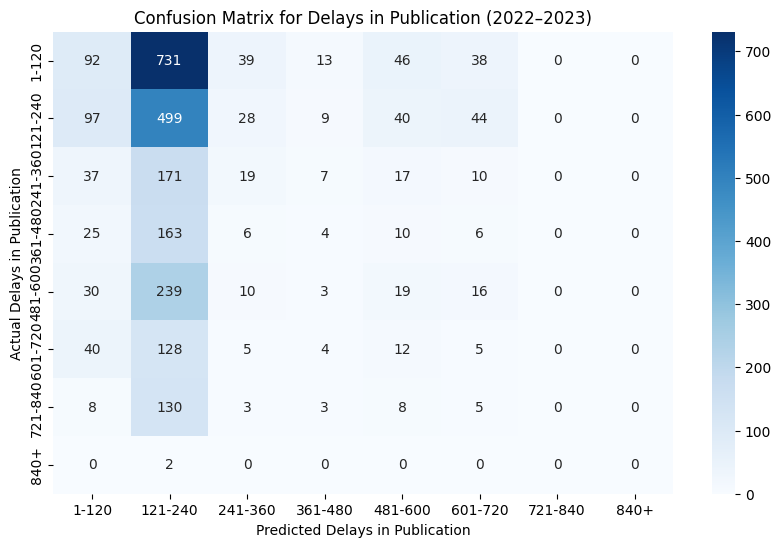

In [75]:
# load and preprocess data (already done from oli_visualizations)
plane_data = pd.read_csv('data/Merged10yrdata.csv')
plane_data['EventDate'] = pd.to_datetime(plane_data['EventDate'])
plane_data['OriginalPublishedDate'] = pd.to_datetime(plane_data['OriginalPublishedDate']) # OriginalPublishDate
plane_data = plane_data[plane_data['Country'] == 'United States']
plane_data['ReportDelay'] = (plane_data['OriginalPublishedDate'] - plane_data['EventDate']).dt.days

# bin the delay
bins = [-np.inf, 120, 240, 360, 480, 600, 720, 840, np.inf]
labels = ['1-120', '121-240', '241-360', '361-480', '481-600', '601-720', '721-840', '840+']
plane_data['DelayCategory'] = pd.cut(plane_data['ReportDelay'], bins=bins, labels=labels)
plane_data['DelayCategory'] = plane_data['DelayCategory'].cat.add_categories(['Not Filed']).fillna('Not Filed')

# extraction
plane_data['DelayDays'] = (plane_data['OriginalPublishedDate'] - plane_data['EventDate']).dt.days
plane_data['EventYear'] = plane_data['EventDate'].dt.year
plane_data['EventMonth'] = plane_data['EventDate'].dt.month
plane_data['EventDayOfWeek'] = plane_data['EventDate'].dt.dayofweek

# encode delay category
le = LabelEncoder()
plane_data['DelayClass'] = le.fit_transform(plane_data['DelayCategory'])

# train on data from 2015–2021
train_df = plane_data[(plane_data['EventYear'] >= 2015) & (plane_data['EventYear'] <= 2021)]
predict_df = plane_data[plane_data['EventYear'] >= 2022]

feature_cols = ['EventYear', 'EventMonth', 'EventDayOfWeek']
X_train = train_df[feature_cols]
y_train = train_df['DelayClass']

# train the model using HistGradientBoostingClassifier
model = HistGradientBoostingClassifier(max_iter=100, learning_rate=0.1)
model.fit(X_train, y_train)

# prepare features for prediction data (2023 onwards)
X_predict = predict_df[feature_cols]

# predict classes for the future data
predicted_classes = model.predict(X_predict)
predict_df['PredictedClass'] = predicted_classes
predict_df['PredictedDelayCategory'] = le.inverse_transform(predicted_classes)

# evaluate the model on known data (2022–2023)
eval_df = predict_df[predict_df['DelayCategory'] != 'Not Filed'] 
if not eval_df.empty:
    # encode the true labels using LabelEncoder
    y_true = le.transform(eval_df['DelayCategory'])
    y_pred = eval_df['PredictedClass']
    
    # get the target class names excluding 'Not Filed'
    target_classes = le.classes_
    target_classes = target_classes[target_classes != 'Not Filed']
    
    # print classification report for evaluation
    print("\nClassification Report (2022–2023 known reports):")
    print(classification_report(y_true, y_pred, target_names=target_classes))

    # confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_classes, yticklabels=target_classes, cmap='Blues')
    plt.xlabel("Predicted Delays in Publication")
    plt.ylabel("Actual Delays in Publication")
    plt.title("Confusion Matrix for Delays in Publication (2022–2023)")
    plt.show()

# export predictions for future data if needed
# predict_df.to_csv('predicted_report_delays_2022_onward.csv', index=False)

In [5]:
plane_data = pd.read_csv('data/Merged10yrdata.csv')

# filter for only US data
plane_data = plane_data[plane_data['Country'] == 'United States']

# convert dates to datetime
plane_data['EventDate'] = pd.to_datetime(plane_data['EventDate'])
plane_data['OriginalPublishedDate'] = pd.to_datetime(plane_data['OriginalPublishedDate'])

# calculate publishing delay in days
plane_data['DelayDays'] = (plane_data['OriginalPublishedDate'] - plane_data['EventDate']).dt.days
plane_data['EventMonth'] = plane_data['EventDate'].dt.month
plane_data['EventDayOfWeek'] = plane_data['EventDate'].dt.dayofweek
plane_data['EventYear'] = plane_data['EventDate'].dt.year

plane_data.head()


C:\Users\Oli\AppData\Local\Temp\ipykernel_26548\1464289538.py:1: DtypeWarning: Columns (7,12,13,14,21,22,32,33,44) have mixed types. Specify dtype option on import or set low_memory=False.
  plane_data = pd.read_csv('data/Merged10yrdata.csv')


,NtsbNo,EventType,Mkey,EventDate,City,State,Country,ReportNo,N#,SerialNumber,...,BroadPhaseofFlight,ReportStatus,RepGenFlag,MostRecentReportType,DocketUrl,ReportUrl,DelayDays,EventMonth,EventDayOfWeek,EventYear
1,WPR15CA073,ACC,90556,2015-01-01 17:07:00+00:00,Yuma,Arizona,United States,NaN,N2841N,13102,...,Takeoff,Completed,NaN,Final,https://data.ntsb.gov/Docket?ProjectID=90556,https://data.ntsb.gov/carol-repgen/api/Aviatio...,67.0,1,3,2015
2,ERA15CA093,ACC,90576,2015-01-01 17:30:00+00:00,Apalachicola,Florida,United States,NaN,N657MC,4622007,...,Taxi,Completed,NaN,Final,https://data.ntsb.gov/Docket?ProjectID=90576,https://data.ntsb.gov/carol-repgen/api/Aviatio...,158.0,1,3,2015
3,ERA15CA089,ACC,90559,2015-01-02 17:40:00+00:00,Barranquitas,Puerto Rico,United States,NaN,N3183T,11550,...,Landing,Completed,NaN,Final,https://data.ntsb.gov/Docket?ProjectID=90559,https://data.ntsb.gov/carol-repgen/api/Aviatio...,149.0,1,4,2015
4,ERA15CA118,ACC,90685,2015-01-02 18:30:00+00:00,Eustis,Florida,United States,NaN,N516VB,TTS61,...,Landing,Completed,NaN,Final,https://data.ntsb.gov/Docket?ProjectID=90685,https://data.ntsb.gov/carol-repgen/api/Aviatio...,207.0,1,4,2015
5,ERA15FA088,ACC,90558,2015-01-02 18:55:00+00:00,Kuttawa,Kentucky,United States,NaN,N81291,34-8070037,...,Enroute,Completed,NaN,Final,https://data.ntsb.gov/Docket?ProjectID=90558,https://data.ntsb.gov/carol-repgen/api/Aviatio...,712.0,1,4,2015


In [7]:
# fill in not filed reports using hot deck imputation
def hot_deck_impute(df):
    df = df.copy()
    group_median = df.groupby(['EventMonth', 'EventDayOfWeek'])['DelayDays'].median()

    def impute(row):
        if pd.isna(row['DelayDays']):
            return group_median.get((row['EventMonth'], row['EventDayOfWeek']), df['DelayDays'].median())
        return row['DelayDays']

    df['DelayDays'] = df.apply(impute, axis=1)
    return df

plane_data = hot_deck_impute(plane_data)

In [34]:
features = ['EventMonth', 'EventDayOfWeek']
X = plane_data[features]
y = plane_data['DelayDays']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train HistGradientBoostingRegressor
model = HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, random_state=42)
model.fit(X_train, y_train)

# evaluate model
y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R^2:", r2_score(y_test, y_pred))

MAE: 259.60606489898737
RMSE: 326.4940696438964
R^2: 0.0021508599912763993


In [ ]:
# Fill in best classifier in your function and re-trian your classifier using all training data
# Get predictions for unlabelled test data
# 2 points credits
classifier = learn_classifier(X, y, best_kernel)
unlabeled_tweets = pd.read_csv("tweets_test.csv", na_filter=False)
y_pred = classify_tweets(tfidf, classifier, unlabeled_tweets)

In [35]:
future_years = range(2025, 2036)
future_events = []

for year in future_years:
    for month in range(1, 13):
        # generate 5 events per month (random day)
        for _ in range(5):
            fake_date = pd.Timestamp(f'{year}-{month:02d}-{np.random.randint(1, 28)}')
            future_events.append({
                'EventDate': fake_date,
                'EventMonth': fake_date.month,
                'EventDayOfWeek': fake_date.dayofweek,
            })

synthetic_future_df = pd.DataFrame(future_events)

# feature extraction
def extract_features(df):
    df = df.copy()
    df['EventMonth'] = df['EventDate'].dt.month
    df['EventDayOfWeek'] = df['EventDate'].dt.dayofweek
    return df[['EventMonth', 'EventDayOfWeek']] 

X_future = extract_features(synthetic_future_df)

# predict using trained model
predicted_delays = model.predict(X_future)

# add predictions to the DataFrame
synthetic_future_df['PredictedDelayDays'] = predicted_delays
synthetic_future_df['Year'] = synthetic_future_df['EventDate'].dt.year
synthetic_future_df['Month'] = synthetic_future_df['EventDate'].dt.month

# group by year and calculate the mean delay
mean_delays_per_year = synthetic_future_df.groupby('Year')['PredictedDelayDays'].mean()

mean_delays_per_year


Year
2025    418.914920
2026    410.802837
2027    408.556108
2028    416.361593
2029    412.556561
2030    412.374333
2031    415.649617
2032    412.482710
2033    416.184141
2034    415.623633
2035    417.443967
Name: PredictedDelayDays, dtype: float64

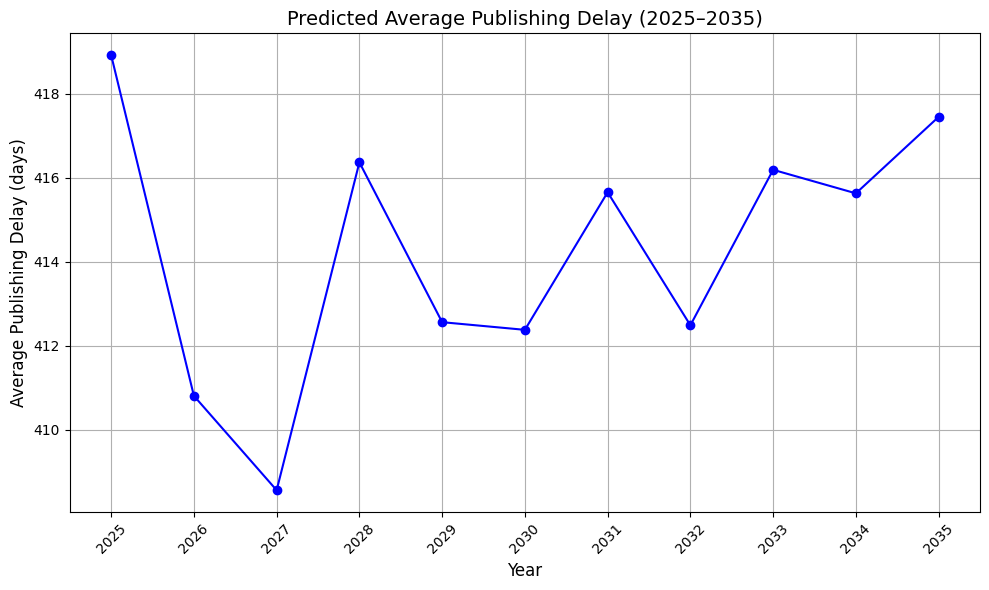

In [36]:
# plot the mean predicted delays per year
plt.figure(figsize=(10, 6))
plt.plot(mean_delays_per_year.index, mean_delays_per_year.values, marker='o', linestyle='-', color='b')
plt.title('Predicted Average Publishing Delay (2025–2035)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Publishing Delay (days)', fontsize=12)
plt.grid(True)
plt.xticks(mean_delays_per_year.index, rotation=45)
plt.tight_layout()
plt.show()